# DPD polymers

This example shows how to initialize a system of copolymers and execute Dissipative particle dynamics simulations.

## Initialize

Import the hoomd python package.

In [1]:
import hoomd

HOOMD-blue v2.1.3 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 02/07/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----


Import the md component to execute MD simulations.

In [2]:
import hoomd.md

Initialize the execution context to control where HOOMD will exeucte the simulation. When no command line options are provided, HOOMD will autoseelct a GPU if it exists, or run on the CPU.

In [3]:
hoomd.context.initialize("")

notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]            Tesla K20c  13 SM_3.5 @ 0.706 GHz, 5060 MiB DRAM


Create a single A7B3 polymer in a snapshot. The box for the snapshot wraps tightly around the polymer, the valid particle types are *A*, and *B*, and the single bond type is *polymer*.

In [4]:
snapshot = hoomd.data.make_snapshot(N=10,
                                    box=hoomd.data.boxdim(Lx=10, Ly=0.5, Lz=0.5),
                                    particle_types=['A', 'B'],
                                    bond_types=['polymer'])

Assign the positions of the polymer in a line. Boxes in hoomd go from $-L/2$ to $L/2$

In [5]:
snapshot.particles.position[:] = [[-4.5, 0, 0], [-3.5, 0, 0], [-2.5, 0, 0], [-1.5, 0, 0], [-0.5, 0, 0], 
                                  [0.5, 0, 0], [1.5, 0, 0], [2.5, 0, 0], [3.5, 0, 0], [4.5, 0, 0]]

Assign the types to make an A7B3 polymer. Based on the order in the ``particle_types`` list, id 0 is *A* and id 1 is *B*.

In [6]:
snapshot.particles.typeid[0:7]=0
snapshot.particles.typeid[7:10]=1
print(snapshot.particles.typeid)

[0 0 0 0 0 0 0 1 1 1]


Create the bonds between neighbors in the chain. By default, the bond type id for every bond is 0, which is type name *polymer* defined above. The bond *groups* define the tags of the particles that participate in the bond.

In [7]:
snapshot.bonds.resize(9)
snapshot.bonds.group[:] = [[0,1], [1, 2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9]]

Replicate the snapshot to create many polymers.

In [8]:
snapshot.replicate(1,20,20)

By default, particles have 0 velocity. Set a gaussian random velocicty using numpy.

In [9]:
import numpy
snapshot.particles.velocity[:] = numpy.random.normal(0.0, numpy.sqrt(0.8 / 1.0), [snapshot.particles.N, 3])

Initialize the system with this snapshot as the system configuration.

In [10]:
hoomd.init.read_snapshot(snapshot)

notice(2): Group "all" created containing 4000 particles


## Define the forces

In the DPD polymer model, pairs of particles closer than $r_\mathrm{cut}$ interact with a linear conservative force, a drag force that depends on the relative velocity, and a random force.

Choose the neighbor list accleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [11]:
nl = hoomd.md.nlist.cell()

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure. $kT$ defines the temperature of the system in energy units and *seed* defines the seed for the random number generator.

In [12]:
dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=0.8, seed=1)

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----


Specify pair potential parameters for every pair of types in the simulation.

In [13]:
dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0)
dpd.pair_coeff.set('A', 'B', A=100.0, gamma = 1.0)
dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0)

By default, HOOMD excludes pair interactions between particles that are directly bonded. The DPD model includes these interactions. Reset the neighbor list exclusions accordingly.

In [14]:
nl.reset_exclusions(exclusions = [])

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no


Apply harmonic bonds between the directly bonded particles.

In [15]:
harmonic = hoomd.md.bond.harmonic()

DPD uses length 0 bonds to keep polymer chains together. The pair repulsion forces the particles apart.

In [16]:
harmonic.bond_coeff.set('polymer', k=100.0, r0=0)

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [17]:
hoomd.md.integrate.mode_standard(dt=0.01)

``pair.dpd`` applies the random and drag forces consitent with a thermal system and should be used with the *NVE* integrator.

In [18]:
all = hoomd.group.all();
hoomd.md.integrate.nve(group=all)

## Write output

Periodically log the potential energy of the system to a text file.

In [19]:
hoomd.analyze.log(filename="log-output.log", quantities=['potential_energy', 'temperature'], period=500, overwrite=True)

Periodically write the particle configurations to a gsd file.

In [20]:
hoomd.dump.gsd("trajectory.gsd", period=10e3, group=all, overwrite=True)

## Run the simulation

Take 50,000 steps forward in time.

In [21]:
hoomd.run(5e4)

** starting run **
Time 00:00:10 | Step 36630 / 50000 | TPS 3662.99 | ETA 00:00:03
Time 00:00:13 | Step 50000 / 50000 | TPS 4133.28 | ETA 00:00:00
Average TPS: 3777.78
---------
-- Neighborlist stats:
9019 normal updates / 168 forced updates / 0 dangerous updates
n_neigh_min: 35 / n_neigh_max: 56 / n_neigh_avg: 45.7085
shortest rebuild period: 2
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **


## Examine the output

Use matplotlib to plot the potential energy vs time step.

In [22]:
import numpy
data = numpy.genfromtxt(fname='log-output.log', skip_header=True)

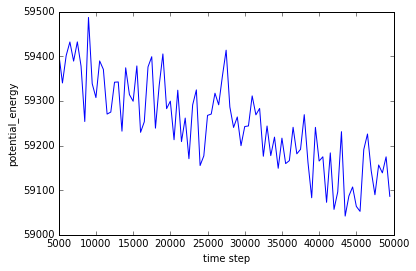

In [26]:
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(data[10:,0], data[10:,1])
pyplot.xlabel('time step')
pyplot.ylabel('potential_energy')

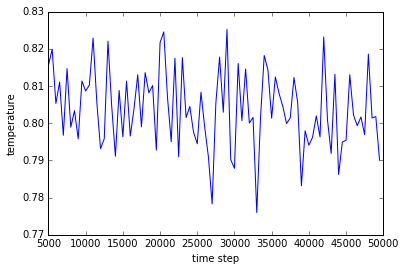

In [27]:
pyplot.plot(data[10:,0], data[10:,2])
pyplot.xlabel('time step')
pyplot.ylabel('temperature')

Size: 279.0048828125 KiB


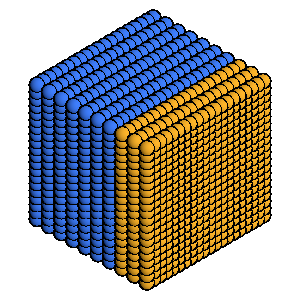

In [25]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd')